# MovieLens Analysis: Between Two Decades

# 1. Import libraries

In [53]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col
from pyspark.sql.functions import abs
from pyspark.sql.functions import format_number
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2. Load the database and present

In [54]:
spark = SparkSession.builder.appName("MovieAnalyze").getOrCreate()

movies_df = spark.read.json("hdfs://namenode:9000/individual/nbs/metadata_updated.json")
rating_count_df = spark.read.json("hdfs://namenode:9000/individual/nbs/rating_count.json")
tag_count_df = spark.read.json("hdfs://namenode:9000/individual/nbs/tag_count.json")
tags_df = spark.read.json("hdfs://namenode:9000/individual/nbs/tags.json")

movies_df.show(n=5)
rating_count_df.show(n=5)
tag_count_df.show(n=5)
tags_df.show(n=5)

+---------+---------------+-------+-------+--------------------+--------------------+
|avgRating|     directedBy| imdbId|item_id|            starring|               title|
+---------+---------------+-------+-------+--------------------+--------------------+
|  3.89146|  John Lasseter|0114709|      1|Tim Allen, Tom Ha...|    Toy Story (1995)|
|  3.26605|   Joe Johnston|0113497|      2|Jonathan Hyde, Br...|      Jumanji (1995)|
|  3.17146|  Howard Deutch|0113228|      3|Jack Lemmon, Walt...|Grumpier Old Men ...|
|  2.86824|Forest Whitaker|0114885|      4|Angela Bassett, L...|Waiting to Exhale...|
|   3.0762|  Charles Shyer|0113041|      5|Steve Martin, Mar...|Father of the Bri...|
+---------+---------------+-------+-------+--------------------+--------------------+
only showing top 5 rows

+-----+-------+
|count|item_id|
+-----+-------+
|15507|      5|
|33239|     10|
| 1981|     13|
|24607|     17|
|25751|     21|
+-----+-------+
only showing top 5 rows

+-------+---+------+
|item_id|nu

# 3. Data preprocess

In [55]:
#This database is very well-organized and does not contain noises and outliers.
#But still the necesary process is needed.

#Extract the needed integer attribute 'year' from the title. Drop unnecessary columns.
movies_df = movies_df.withColumn("year", regexp_extract(movies_df["title"], r"\((\d{4})\)", 1).cast("integer"))
movies_df = movies_df.select("title", "year", "avgRating", "item_id")

#Filter movies with more than 10 ratings to improve the data quality.
solid_rated_movies_df = movies_df.join(rating_count_df, on="item_id", how="left").filter((col("count") >= 10) | col("count").isNull())
#Filter movies above 3.5 out of 5 score as "Good movies"
good_movies_df = solid_rated_movies_df.filter(movies_df["avgRating"] > 3.5)

good_movies_df.show(n=5)

+-------+--------------------+----+---------+-----+
|item_id|               title|year|avgRating|count|
+-------+--------------------+----+---------+-----+
|      1|    Toy Story (1995)|1995|  3.89146|68884|
|      6|         Heat (1995)|1995|  3.85549|28956|
|     11|American Presiden...|1995|  3.66058|19724|
|     16|       Casino (1995)|1995|  3.82016|21392|
|     17|Sense and Sensibi...|1995|  3.94589|24607|
+-------+--------------------+----+---------+-----+
only showing top 5 rows



# 4. Filter the 2012-2021 decade movies

In [56]:
recent_total_df = movies_df.filter((col("year") >= 2012) & (col("year") <= 2021))
recent_total = recent_total_df.count()
recent_total_df.show(n=5)

recent_decade_df = good_movies_df.filter((col("year") >= 2012) & (col("year") <= 2021))
recent_count = recent_decade_df.count()
recent_decade_df.show(n=5)

+--------------------+----+---------+-------+
|               title|year|avgRating|item_id|
+--------------------+----+---------+-------+
|Avengers, The (2012)|2012|  3.76248|  89745|
|Bullet to the Hea...|2012|   2.6864|  91483|
|Expendables 2, Th...|2012|  2.95248|  91485|
|The Hunger Games ...|2012|  3.51419|  91500|
|Dark Knight Rises...|2012|  3.97472|  91529|
+--------------------+----+---------+-------+
only showing top 5 rows

+-------+--------------------+----+---------+-----+
|item_id|               title|year|avgRating|count|
+-------+--------------------+----+---------+-----+
|  89745|Avengers, The (2012)|2012|  3.76248|18247|
|  91500|The Hunger Games ...|2012|  3.51419|14156|
|  91529|Dark Knight Rises...|2012|  3.97472|20411|
|  92420|    Chronicle (2012)|2012|  3.60015| 2730|
|  92509|     Vow, The (2012)|2012|  3.57644| 1032|
+-------+--------------------+----+---------+-----+
only showing top 5 rows



# 5. Filter the 2002-2011 decade movies and show significant numbers

In [57]:
far_total_df = movies_df.filter((col("year") >= 2002) & (col("year") <= 2011))
far_total = far_total_df.count()
far_total_df.show(n=5)

far_decade_df = good_movies_df.filter((col("year") >= 2002) & (col("year") <= 2011))
far_count = far_decade_df.count()
far_decade_df.show(n=5)

print("Total movies for 2012-2021: " + str(recent_total) + 
      "\nTotal movies for 2002-2011: " + str(far_total) + 
      "\nGood movies for 2012-2021: " + str(recent_count) + 
      "\nGood movies for 2002-2011: " + str(far_count))

+--------------------+----+---------+-------+
|               title|year|avgRating|item_id|
+--------------------+----+---------+-------+
|Waking Up in Reno...|2002|  2.68072|   4746|
|  Big Trouble (2002)|2002|  3.23464|   4774|
|Orange County (2002)|2002|  3.08933|   5025|
|     Impostor (2002)|2002|  3.16688|   5046|
|Kung Pow: Enter t...|2002|   2.7881|   5047|
+--------------------+----+---------+-------+
only showing top 5 rows

+-------+--------------------+----+---------+-----+
|item_id|               title|year|avgRating|count|
+-------+--------------------+----+---------+-----+
|   5064|The Count of Mont...|2002|  3.79183| 6960|
|   5152|We Were Soldiers ...|2002|   3.5721| 4380|
|   5218|      Ice Age (2002)|2002|  3.53431|19582|
|   5329|Salton Sea, The (...|2002|  3.57527| 1158|
|   5377|  About a Boy (2002)|2002|  3.63151|11950|
+-------+--------------------+----+---------+-----+
only showing top 5 rows

Total movies for 2012-2021: 26695
Total movies for 2002-2011: 18322


# 6. Visualize the good movie percentage for 2012-2021

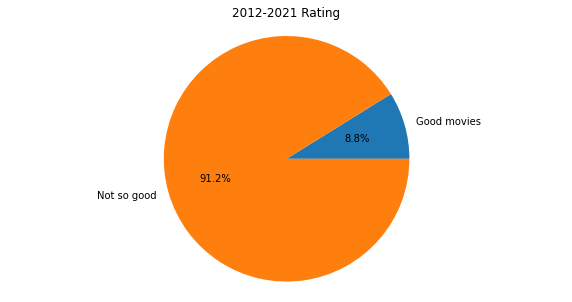

In [58]:
recent_good_percent = recent_count / recent_total
recent_bad_percent = 1 - recent_good_percent

labels = ['Good movies', 'Not so good']
sizes = [recent_good_percent, recent_bad_percent]

plt.figure(figsize=(10, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('2012-2021 Rating')
plt.axis('equal')

plt.show()

# 7. Visualize the good movie percentage for 2002-2011

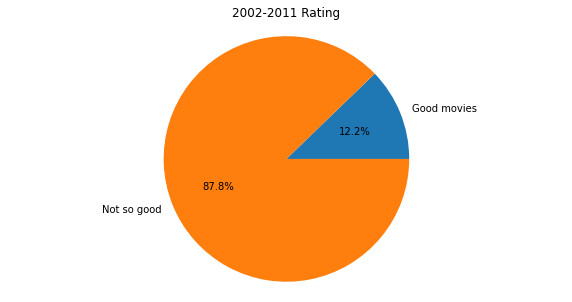

In [59]:
far_good_percent = far_count / far_total
far_bad_percent = 1 - far_good_percent

labels = ['Good movies', 'Not so good']
sizes = [far_good_percent, far_bad_percent]

plt.figure(figsize=(10, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('2002-2011 Rating')
plt.axis('equal')

plt.show()

# 8. Calculate the most common tags in 2012-2021 total movies

In [60]:
recent_total_tags = recent_total_df.join(tag_count_df, "item_id")
recent_total_counts = recent_total_tags.groupBy("tag_id").count()

recent_total_counts = recent_total_counts.join(tags_df, recent_total_counts["tag_id"] == tags_df["id"])
recent_total_counts = recent_total_counts.sort(col("count").desc())

recent_total_counts.select("tag", "count").show()

+---------------+-----+
|            tag|count|
+---------------+-----+
|          drama|  668|
|         comedy|  612|
|         murder|  558|
|    documentary|  526|
|         family|  511|
|        romance|  474|
|     friendship|  430|
|         action|  430|
|          funny|  420|
|         boring|  400|
|      biography|  398|
|       violence|  385|
|         horror|  366|
|           love|  361|
|        revenge|  346|
|          crime|  327|
|stand-up comedy|  323|
|       thriller|  318|
|          music|  307|
|    predictable|  306|
+---------------+-----+
only showing top 20 rows



# 9. Calculate the most common tags in 2012-2021 high rating movies

In [61]:
recent_decade_tags = recent_decade_df.join(tag_count_df, "item_id")
recent_tag_counts = recent_decade_tags.groupBy("tag_id").count()

recent_tag_counts = recent_tag_counts.join(tags_df, recent_tag_counts["tag_id"] == tags_df["id"])
recent_tag_counts = recent_tag_counts.withColumn("percent", format_number((recent_tag_counts["count"] / recent_count) * 100, 4))
recent_tag_counts = recent_tag_counts.sort(col("count").desc())

recent_tag_counts.select("tag_id", "tag", "count", "percent").show()


+------+--------------------+-----+-------+
|tag_id|                 tag|count|percent|
+------+--------------------+-----+-------+
| 86247|               drama|  269|11.3983|
| 94577|         documentary|  193| 8.1780|
| 90720|              family|  162| 6.8644|
| 37108|              comedy|  145| 6.1441|
| 58352|              boring|  142| 6.0169|
| 35012|             romance|  136| 5.7627|
| 10736|          friendship|  135| 5.7203|
| 60591|               funny|  133| 5.6356|
|101162|           biography|  125| 5.2966|
| 78736|      cinematography|  121| 5.1271|
| 63379|based on a true s...|  118| 5.0000|
| 58846|                love|  117| 4.9576|
| 71336|            violence|  113| 4.7881|
| 42940|              action|  111| 4.7034|
|  6528|               music|  110| 4.6610|
| 66794|              murder|  108| 4.5763|
|  9953|       coming of age|  107| 4.5339|
|  3175|               death|   99| 4.1949|
|  4557|         predictable|   97| 4.1102|
| 65332|               crime|   

# 10. Calculate the most common tags in 2012-2021 total movies

In [62]:
far_total_tags = far_total_df.join(tag_count_df, "item_id")
far_total_counts = far_total_tags.groupBy("tag_id").count()

far_total_counts = far_total_counts.join(tags_df, far_total_counts["tag_id"] == tags_df["id"])
far_total_counts = far_total_counts.sort(col("count").desc())

far_total_counts.select("tag", "count").show()

+----------------+-----+
|             tag|count|
+----------------+-----+
|independent film|  962|
|nudity (topless)|  657|
|          comedy|  605|
|          murder|  559|
|         romance|  513|
|           funny|  497|
|           drama|  457|
| based on a book|  456|
|        violence|  438|
|          boring|  434|
|            love|  387|
|      friendship|  382|
|          action|  372|
|     documentary|  353|
|             sex|  326|
|         revenge|  323|
|          family|  318|
|           music|  313|
|     predictable|  310|
|           drugs|  307|
+----------------+-----+
only showing top 20 rows



# 11. Calculate the most common tags in 2002-2011 high rating movies

In [63]:
far_decade_tags = far_decade_df.join(tag_count_df, "item_id")
far_tag_counts = far_decade_tags.groupBy("tag_id").count()

far_tag_counts = far_tag_counts.join(tags_df, far_tag_counts["tag_id"] == tags_df["id"])
far_tag_counts = far_tag_counts.withColumn("percent", format_number((far_tag_counts["count"] / far_count) * 100, 4))
far_tag_counts = far_tag_counts.sort(col("count").desc())

far_tag_counts.select("tag_id", "tag", "count", "percent").show()

+------+-----------------+-----+-------+
|tag_id|              tag|count|percent|
+------+-----------------+-----+-------+
| 86247|            drama|  199| 8.8879|
| 21285|  based on a book|  183| 8.1733|
| 58352|           boring|  181| 8.0840|
| 35012|          romance|  173| 7.7267|
| 11329| independent film|  172| 7.6820|
| 94577|      documentary|  167| 7.4587|
| 60591|            funny|  166| 7.4140|
| 66794|           murder|  159| 7.1014|
| 37108|           comedy|  149| 6.6548|
| 71336|         violence|  148| 6.6101|
| 10736|       friendship|  148| 6.6101|
|  6528|            music|  145| 6.4761|
| 58846|             love|  138| 6.1635|
| 78736|   cinematography|  132| 5.8955|
| 25514| nudity (topless)|  131| 5.8508|
| 87183|             slow|  123| 5.4935|
| 90720|           family|  108| 4.8236|
| 86819|         politics|  108| 4.8236|
| 78672|social commentary|  103| 4.6003|
|  7923|      atmospheric|  103| 4.6003|
+------+-----------------+-----+-------+
only showing top

# 12. Visualize most common tags in 2012-2021 for high ratings

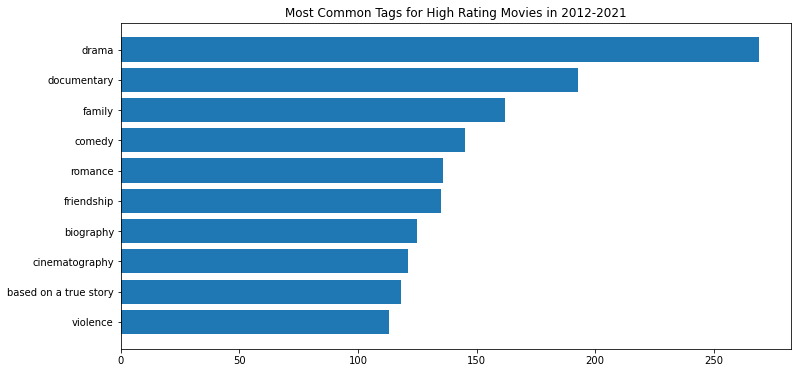

In [64]:
#Remove repetitive or low-value tags
recent_top_10_tags = recent_tag_counts.filter(~recent_tag_counts["tag_id"].isin([58352, 60591, 58846, 3175, 4557])).limit(10)

recent_tag_names = recent_top_10_tags.select("tag").rdd.map(lambda x: x[0]).collect()
recent_tag_nums = recent_top_10_tags.select("count").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12, 6))
plt.barh(recent_tag_names, recent_tag_nums)
plt.title('Most Common Tags for High Rating Movies in 2012-2021')
plt.gca().invert_yaxis()
plt.show()

# 13. Visualize most common tags in 2002-2011

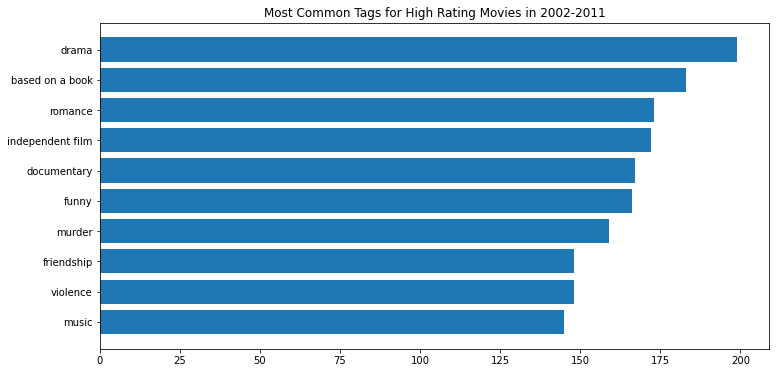

In [65]:
#Remove repetitive or low-value tags
far_top_10_tags = far_tag_counts.filter(~far_tag_counts["tag_id"].isin([58352, 37108, 58846, 25514, 18966])).limit(10)

far_tag_names = far_top_10_tags.select("tag").rdd.map(lambda x: x[0]).collect()
far_tag_nums = far_top_10_tags.select("count").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12, 6))
plt.barh(far_tag_names, far_tag_nums)
plt.title('Most Common Tags for High Rating Movies in 2002-2011')
plt.gca().invert_yaxis()
plt.show()

# 14. Calculate the tag percent changes for two decades. Display most increased tags.

In [66]:
recent_tag_counts_tojoin = recent_tag_counts.withColumnRenamed("tag_id", "tag_id_recent") \
    .withColumnRenamed("count", "count_recent") \
    .withColumnRenamed("id", "id_recent") \
    .withColumnRenamed("tag", "tag_recent") \
    .withColumnRenamed("percent", "percent_recent")

far_tag_counts_tojoin = far_tag_counts.withColumnRenamed("tag_id", "tag_id_far") \
    .withColumnRenamed("count", "count_far") \
    .withColumnRenamed("id", "id_far") \
    .withColumnRenamed("tag", "tag_far") \
    .withColumnRenamed("percent", "percent_far")

tag_percent_change = recent_tag_counts_tojoin.join(far_tag_counts_tojoin, 
                                            recent_tag_counts_tojoin["tag_id_recent"] == far_tag_counts_tojoin["tag_id_far"], how="inner")
tag_percent_change = tag_percent_change.withColumn("percent_change", 
                                                   tag_percent_change["percent_recent"] - tag_percent_change["percent_far"])
tag_percent_change = tag_percent_change.withColumn("percent_change", format_number(tag_percent_change["percent_change"], 4))

tag_percent_change = tag_percent_change.withColumn("percent_change", tag_percent_change["percent_change"].cast(DoubleType()))

top_increase = tag_percent_change.sort(col("percent_change").desc())
top_increase.select("tag_id_recent", "tag_recent", "percent_recent", "percent_far", "percent_change").show()



+-------------+--------------------+--------------+-----------+--------------+
|tag_id_recent|          tag_recent|percent_recent|percent_far|percent_change|
+-------------+--------------------+--------------+-----------+--------------+
|        86247|               drama|       11.3983|     8.8879|        2.5104|
|        90720|              family|        6.8644|     4.8236|        2.0408|
|        11539|father daughter r...|        2.7966|     1.5632|        1.2334|
|       101162|           biography|        5.2966|     4.1983|        1.0983|
|       108793|            teenager|        2.2034|     1.1166|        1.0868|
|        24018|          plot twist|        1.9915|     1.0272|        0.9643|
|        92456|mother daughter r...|        2.2034|     1.2506|        0.9528|
|       104610|           superhero|        1.7373|     0.8486|        0.8887|
|         9530|              marvel|        0.9746|     0.1787|        0.7959|
|        94577|         documentary|        8.1780| 

# 15. Display most decreased tags

In [67]:
tag_percent_decrease = tag_percent_change.withColumn("percent_change", -tag_percent_change["percent_change"])
top_decrease = tag_percent_decrease.sort(col("percent_change").desc())

top_decrease.select("tag_id_recent", "tag_recent", "percent_recent", "percent_far", "percent_change").show()

+-------------+-----------------+--------------+-----------+--------------+
|tag_id_recent|       tag_recent|percent_recent|percent_far|percent_change|
+-------------+-----------------+--------------+-----------+--------------+
|        11329| independent film|        0.9746|     7.6820|        6.7074|
|        25514| nudity (topless)|        1.5254|     5.8508|        4.3254|
|        21285|  based on a book|        3.8983|     8.1733|         4.275|
|        60807|adapted from:book|        0.7203|     4.2430|        3.5227|
|        66794|           murder|        4.5763|     7.1014|        2.5251|
|        52344|           quirky|        2.0339|     4.4663|        2.4324|
|        63677|     imdb top 250|        1.0593|     3.4390|        2.3797|
|        87183|             slow|        3.2627|     5.4935|        2.2308|
|        61398|         stylized|        1.5678|     3.7963|        2.2285|
|        18699|        overrated|        2.5000|     4.6003|        2.1003|
|        583

# 16. Visualize tag increased

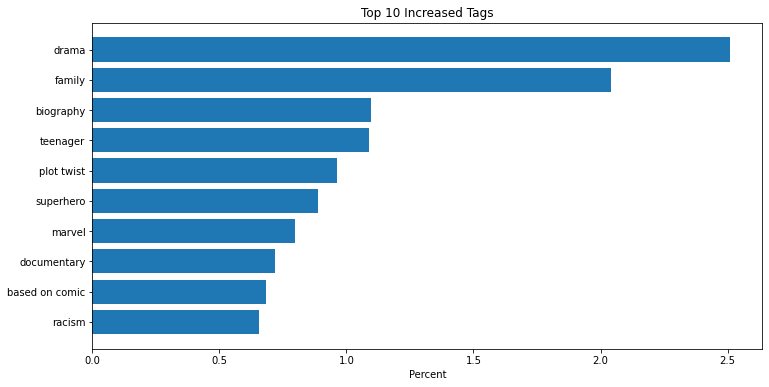

In [68]:
filtered_top_increase = top_increase.filter(~top_increase["tag_id_recent"].isin([11539, 92456])).limit(10)

increased_tag_names = filtered_top_increase.select("tag_recent").rdd.map(lambda x: x[0]).collect()
increased_percent = filtered_top_increase.select("percent_change").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12, 6))
plt.barh(increased_tag_names, increased_percent)
plt.title('Top 10 Increased Tags')
plt.xlabel('Percent')
plt.gca().invert_yaxis()

plt.show()

# 17. Visualize tags decreased

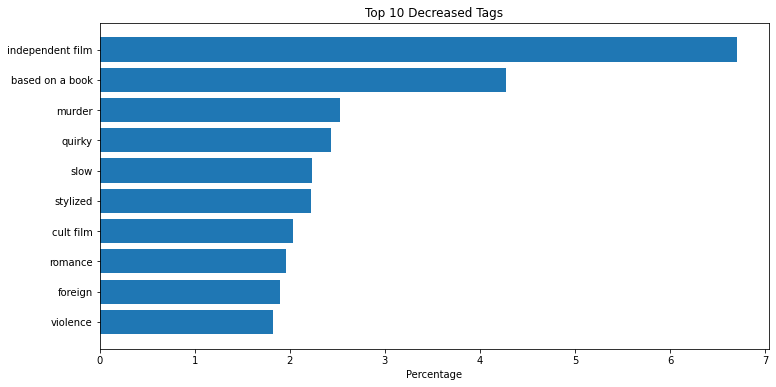

In [69]:
filtered_top_decrease = top_decrease.filter(~top_increase["tag_id_recent"].isin([25514, 92456, 60807, 63677, 18699, 58352])).limit(10)

decreased_tag_names = filtered_top_decrease.select("tag_recent").rdd.map(lambda x: x[0]).collect()
decreased_percent = filtered_top_decrease.select("percent_change").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(12, 6))
plt.barh(decreased_tag_names, decreased_percent)
plt.title('Top 10 Decreased Tags')
plt.xlabel('Percentage')
plt.gca().invert_yaxis()

plt.show()

# 18. Special analysis: Comic-Adaptations

In [70]:
recent_total_counts_tojoin = recent_total_counts.withColumnRenamed("count", "total_count")
recent_tag_counts_tojoin = recent_tag_counts.withColumnRenamed("count", "good_count").withColumnRenamed("tag", "tag_recent")

recent_combine_counts = recent_total_counts_tojoin.join(recent_tag_counts_tojoin, 
                                                        recent_total_counts_tojoin["tag"] == recent_tag_counts_tojoin["tag_recent"])

comic_tags = ["superhero", "marvel", "based on comic"]
recent_comic_counts = recent_combine_counts.filter(recent_combine_counts["tag"].isin(comic_tags))

recent_comic_counts = recent_comic_counts.withColumn("percent", (col("good_count") / col("total_count")) * 100)
recent_comic_counts = recent_comic_counts.withColumn("percent", format_number(col("percent"), 2))

recent_comic_counts.select("tag", "total_count", "good_count", "percent").show()

+--------------+-----------+----------+-------+
|           tag|total_count|good_count|percent|
+--------------+-----------+----------+-------+
|based on comic|        108|        34|  31.48|
|     superhero|        131|        41|  31.30|
|        marvel|         44|        23|  52.27|
+--------------+-----------+----------+-------+



In [71]:
far_total_counts_tojoin = far_total_counts.withColumnRenamed("count", "total_count")
far_tag_counts_tojoin = far_tag_counts.withColumnRenamed("count", "good_count").withColumnRenamed("tag", "tag_far")

far_combine_counts = far_total_counts_tojoin.join(far_tag_counts_tojoin, 
                                                        far_total_counts_tojoin["tag"] == far_tag_counts_tojoin["tag_far"])

far_comic_counts = far_combine_counts.filter(far_combine_counts["tag"].isin(comic_tags))

far_comic_counts = far_comic_counts.withColumn("percent", (col("good_count") / col("total_count")) * 100)
far_comic_counts = far_comic_counts.withColumn("percent", format_number(col("percent"), 2))

far_comic_counts.select("tag", "total_count", "good_count", "percent").show()

+--------------+-----------+----------+-------+
|           tag|total_count|good_count|percent|
+--------------+-----------+----------+-------+
|based on comic|         70|        17|  24.29|
|     superhero|        108|        19|  17.59|
|        marvel|         25|         4|  16.00|
+--------------+-----------+----------+-------+



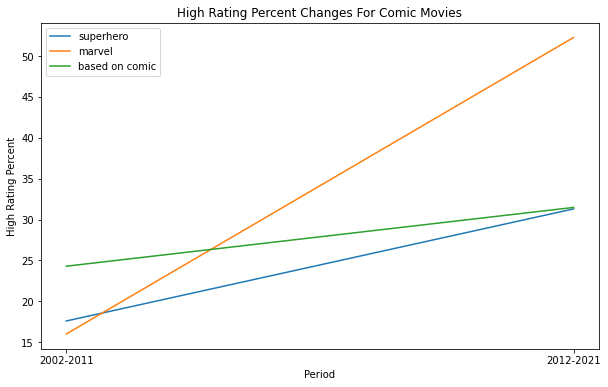

In [72]:
recent_comic_counts_pd = recent_comic_counts.toPandas()
far_comic_counts_pd = far_comic_counts.toPandas()

plt.figure(figsize=(10, 6))
comic_tags = ["superhero", "marvel", "based on comic"]

for tag in comic_tags:
    plt.plot(['2002-2011', '2012-2021'], 
             [float(far_comic_counts_pd[far_comic_counts_pd['tag'] == tag]['percent'].values[0]), 
              float(recent_comic_counts_pd[recent_comic_counts_pd['tag'] == tag]['percent'].values[0])], 
             label=tag)

plt.title('High Rating Percent Changes For Comic Movies')
plt.xlabel('Period')
plt.ylabel('High Rating Percent')

plt.legend()

plt.show()

# 19. Special analysis: Violent Movies

In [73]:
violent_tags = ["murder", "violence"]
recent_violent_counts = recent_combine_counts.filter(recent_combine_counts["tag"].isin(violent_tags))

recent_violent_counts = recent_violent_counts.withColumn("percent", (col("good_count") / col("total_count")) * 100)
recent_violent_counts = recent_violent_counts.withColumn("percent", format_number(col("percent"), 2))

recent_violent_counts.select("tag", "total_count", "good_count", "percent").show()

+--------+-----------+----------+-------+
|     tag|total_count|good_count|percent|
+--------+-----------+----------+-------+
|  murder|        558|       108|  19.35|
|violence|        385|       113|  29.35|
+--------+-----------+----------+-------+



In [74]:
far_violent_counts = far_combine_counts.filter(far_combine_counts["tag"].isin(violent_tags))

far_violent_counts = far_violent_counts.withColumn("percent", (col("good_count") / col("total_count")) * 100)
far_violent_counts = far_violent_counts.withColumn("percent", format_number(col("percent"), 2))

far_violent_counts.select("tag", "total_count", "good_count", "percent").show()

+--------+-----------+----------+-------+
|     tag|total_count|good_count|percent|
+--------+-----------+----------+-------+
|  murder|        559|       159|  28.44|
|violence|        438|       148|  33.79|
+--------+-----------+----------+-------+



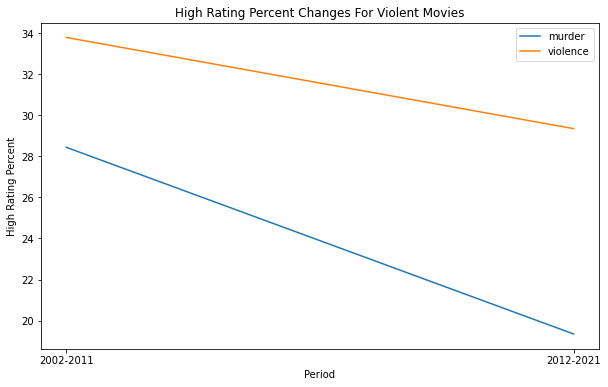

In [75]:
recent_violent_counts_pd = recent_violent_counts.toPandas()
far_violent_counts_pd = far_violent_counts.toPandas()

plt.figure(figsize=(10, 6))
violent_tags = ["murder", "violence"]

for tag in violent_tags:
    plt.plot(['2002-2011', '2012-2021'], 
             [float(far_violent_counts_pd[far_violent_counts_pd['tag'] == tag]['percent'].values[0]), 
              float(recent_violent_counts_pd[recent_violent_counts_pd['tag'] == tag]['percent'].values[0])], 
             label=tag)

plt.title('High Rating Percent Changes For Violent Movies')
plt.xlabel('Period')
plt.ylabel('High Rating Percent')

plt.legend()

plt.show()

# Conclusion

From data analysis above, there have been some changes in the audience's taste for movies. 
Family, teenager, and biographic genres are becoming more popular, and it's especially worth mentioning that comic adaptations, with the concept of the Marvel Universe, have seen a significant increase in the number of films and in audience acclaim over the past decade. Some of the genres that have seen less favorable reviews include violent crime films, romance, and novel adaptations. 
Hollywood may want to consider these kind of movies carefully when planning new productions.